# T026 · Kinase similarity: Interaction fingerprints

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Dominique Sydow, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Talia B. Kimber, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Andrea Volkamer, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)

## Aim of this talktorial

We will assess the similarity between a set of kinases based on detected protein-ligand interactions in available complex structures. The [KLIFS](https://klifs.net/) interaction fingerprint (IFP), which describes the interactions seen in a structurally resolved kinase-ligand complex, will be used in this exercise.  

_Note_: We focus on similarities between orthosteric kinase binding sites; similarities to allosteric binding sites are not covered.

### Contents in *Theory*

* Kinase dataset
* Kinase similarity descriptor: KLIFS interaction fingerprint
* Fetching KLIFS data with `opencadd.databases.klifs`

### Contents in *Practical*

* Define the kinases of interest
* Retrieve and preprocess data
    * Set up a remote KLIFS session
    * Fetch all structures describing these kinases
    * Filter structures
    * Fetch the structures' IFPs (if available)
    * Merge structural and IFP data
* Show kinase coverage
* Compare structures
    * Prepare IFPs as `numpy` array
    * Calculate pairwise Jaccard distances
* Map structure to kinase distance matrix
* Save kinase distance matrix

### References

* Kinase dataset: [<i>Molecules</i> (2021), <b>26(3)</b>, 629](https://www.mdpi.com/1420-3049/26/3/629) 
* Protein Data Bank
  * PDB URL: http://www.rcsb.org/
  * PDB database: [<i>Acta Cryst.</i> (2002), <b>D58</b>, 899-907](https://doi.org/10.1107/S0907444902003451) and [<i>Structure</i> (2012), <b>20(3)</b>, 391-396](https://doi.org/10.1016/j.str.2012.01.010)
* KLIFS
  * KLIFS URL: https://klifs.net/
  * KLIFS database: [<i>Nucleic Acid Res.</i> (2020), <b>49(D1)</b>, D562-D569](https://doi.org/10.1093/nar/gkaa895)
  * KLIFS binding site definition and interaction fingerprint calculation: [<i>J. Med. Chem.</i> (2014), <b>57(2)</b>, 249-277](https://doi.org/10.1021/jm400378w)
* Interaction fingerprint (IFP): [<i>J. Chem. Inf. Model.</i> (2007), <b>71(1)</b>, 195-207](https://doi.org/10.1021/ci600342e)
* `opencadd`, a Python library for structural cheminformatics
  * GitHub repository: https://github.com/volkamerlab/opencadd
  * Documentation: https://opencadd.readthedocs.io

## Theory

### Kinase dataset

We use the kinase selection as defined in __Talktorial T023__.

### Kinase similarity descriptor: KLIFS interaction fingerprints

Interaction fingerprints (IFPs) encode the binding mode of a ligand in a binding site, i.e., the protein-ligand interactions that are present in a structurally resolved complex. If a ligand can form similar interaction patterns in proteins other than its designated protein (off- vs. on-target), it is possible that this ligand will cause unintended side effects. Knowledge about similarities between proteins can therefore help to avoid such off-target effects; or to exploit the known similarities for polypharmacology effects where one ligand could intentionally target multiple proteins at once.

In this talktorial, we are interested in assessing the similarity between a set of kinases based on the similarity between the binding modes of the co-crystallized ligands. 
We will make use of the KLIFS IFP: For each kinase structure that is co-crystallized with a ligand, all interactions between the $85$ KLIFS pocket residues (see more details in __Talktorial T023__) and the ligand are described using the IFP by Marcou and Rognan ([<i>JCIM</i> (2007), <b>71(1)</b>, 195-207](https://pubs.acs.org/doi/10.1021/ci600342e)).

This is how the IFP is explained in the respective KLIFS publication [<i>J. Med. Chem.</i> (2014), <b>57(2)</b>, 249-277](https://doi.org/10.1021/jm400378w):

> For each amino acid in the catalytic cleft, seven types of protein−ligand interactions are determined. The presence of a certain type of interaction results in the type-setting of a “1” in the bit-string; otherwise a “0” is used to indicate the absence of the interaction. The following seven types of interactions are summarized in one bit-string; bit 1 = hydrophobic contact (HYD); bit 2 = face to face aromatic interactions (F−F); bit 3 = face to edge aromatic interactions (F−E); bit 4 = protein H-bond donor (DON); bit 5 = protein H- bond acceptor (ACC); bit 6 = protein cationic interactions (ION+), and bit 7 = protein anionic interactions (ION−).

This results in a $85 \times 7 = 595$ bit vector. Since the binding site is aligned across all kinases, each bit position in this IFP can be directly compared across all IFPs in KLIFS. This is what we will do in the practical part of this tutorial.

![KLIFS IFP](images/T026_KLIFS_IFP.png)

*Figure 1:* 
KLIFS interaction fingerprint (IFP) definition: Seven interaction types are detected between each of a kinase structure's $85$ pocket residues and a co-crystallized ligand. Interaction types include: hydrophobic contact (HYD), face to face aromatic interactions (F−F), face to edge aromatic interactions (F−E), protein H-bond donor (DON), protein H-bond acceptor (ACC), protein cationic interactions (ION+), and protein anionic interactions (ION−).
Figure by Dominique Sydow, adapted from: [<i>J. Med. Chem.</i> (2014), <b>57(2)</b>, 249-277](https://doi.org/10.1021/jm400378w).

### Fetching KLIFS data with `opencadd.databases.klifs`

`opencadd` is a Python library for structural cheminformatics developed by the [Volkamer lab](https://volkamerlab.org/) at the Charité in Berlin. 
This library is a growing collection of modules that help facilitate and standardize common tasks in structural bioinformatics and cheminformatics. Today, we will use the module `opencadd.databases.klifs`, which allows us to fetch the KLIFS IFP as a `pandas` DataFrame.

- GitHub repository: https://github.com/volkamerlab/opencadd
- Documentation: https://opencadd.readthedocs.io

For more information about this library and the KLIFS OpenAPI, please refer to __Talktorial T012__.

## Practical

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance
from opencadd.databases.klifs import setup_remote

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [3]:
configs = pd.read_csv(HERE / "../T023_what_is_a_kinase/data/pipeline_configs.csv")
configs = configs.set_index("variable")["default_value"]

DEMO = bool(int(configs["DEMO"]))
N_STRUCTURES_PER_KINASE = int(configs["N_STRUCTURES_PER_KINASE"])
N_CORES = int(configs["N_CORES"])

print(f"Run in demo mode: {DEMO}")
if not DEMO:
    if N_STRUCTURES_PER_KINASE > 0:
        print(f"Number of structures per kinase: {N_STRUCTURES_PER_KINASE}")
    else:
        print(f"Number of structures per kinase: all available structures")
    print(f"Number of cores used: {N_CORES}")

# NBVAL_CHECK_OUTPUT

Run in demo mode: True


### Define the kinases of interest

Let's load the kinase selection as defined in __Talktorial T023__.

In [4]:
kinase_selection_df = pd.read_csv(HERE / "../T023_what_is_a_kinase/data/kinase_selection.csv")
kinase_selection_df
# NBVAL_CHECK_OUTPUT

,kinase,kinase_klifs,uniprot_id,group,full_kinase_name
0,EGFR,EGFR,P00533,TK,Epidermal growth factor receptor
1,ErbB2,ErbB2,P04626,TK,Erythroblastic leukemia viral oncogene homolog 2
2,PI3K,p110a,P42336,Atypical,Phosphatidylinositol-3-kinase
3,VEGFR2,KDR,P35968,TK,Vascular endothelial growth factor receptor 2
4,BRAF,BRAF,P15056,TKL,Rapidly accelerated fibrosarcoma isoform B
5,CDK2,CDK2,P24941,CMGC,Cyclic-dependent kinase 2
6,LCK,LCK,P06239,TK,Lymphocyte-specific protein tyrosine kinase
7,MET,MET,P08581,TK,Mesenchymal-epithelial transition factor
8,p38a,p38a,Q16539,CMGC,p38 mitogen activated protein kinase alpha


### Retrieve and preprocess data

Now, we query the KLIFS database using the `opencadd.databases.klifs` module to generate our IFP dataset.

#### Set up a remote KLIFS session

In [5]:
from opencadd.databases.klifs import setup_remote

In [6]:
klifs_session = setup_remote()

#### Fetch all structures describing these kinases

In [7]:
# Get list of kinase names
kinase_names = kinase_selection_df["kinase_klifs"].to_list()

# Get all available structures for these kinases
structures_df = klifs_session.structures.by_kinase_name(kinase_names=kinase_names)
# Keep only relevant columns
structures_df = structures_df[
    [
        "structure.klifs_id",
        "kinase.klifs_name",
        "species.klifs",
        "structure.dfg",
        "structure.resolution",
        "structure.qualityscore",
    ]
]
print(f"Number of structures: {len(structures_df)}")
print("Kinases:", *structures_df["kinase.klifs_name"].unique())

Number of structures: 2718
Kinases: CDK2 p38a EGFR ErbB2 MET LCK KDR BRAF p110a


#### Filter structures

We filter the structures by different criteria:

- Species: human
- Conformation: DFG-in (the active kinase conformation)
- Resolution: $\le 3$ Angström
- Quality score*: $\ge 6$

\* The KLIFS quality score takes into account the quality of the alignment, as well as the number of missing residues and atoms. A higher score indicates a better structure quality.

In [8]:
structures_df = structures_df[
    (structures_df["species.klifs"] == "Human")
    & (structures_df["structure.dfg"] == "in")
    & (structures_df["structure.resolution"] <= 3)
    & (structures_df["structure.qualityscore"] >= 6)
]
print(f"Number of structures: {len(structures_df)}")
print("Kinases:", *structures_df["kinase.klifs_name"].unique())

Number of structures: 1792
Kinases: CDK2 p38a EGFR ErbB2 MET LCK KDR BRAF p110a


Save the structure KLIFS IDs for the next step.

In [9]:
structure_klifs_ids = structures_df["structure.klifs_id"].to_list()
print(f"Number of structures: {len(structure_klifs_ids)}")

Number of structures: 1792


_Note for demo mode_: To make it easier for us to maintain the talktorials, we will now load a set of frozen structure KLIFS IDs (2021-08-23) and continue to work with those.

_Note for non-demo mode_: Did you specify `N_STRUCTURES_PER_KINASE` in the configuration file? If you e.g. set a value of 3, we will select in the following the top 3 structures per kinase in terms of resolution and KLIFS quality score.

In [10]:
if DEMO:
    # Load frozen dataset
    print("Notebook is run in demo mode - load frozen structure set.")
    structure_klifs_ids = pd.read_csv(DATA / "frozen_structure_klifs_ids.csv")[
        "structure.klifs_id"
    ].to_list()
    structures_df = structures_df[
        structures_df["structure.klifs_id"].isin(structure_klifs_ids)
    ].copy()
else:
    if N_STRUCTURES_PER_KINASE > 0:
        print(f"Select {N_STRUCTURES_PER_KINASE} structures per kinase for downstream analysis.")
        # Sort structures by kinase and quality
        structures_df = structures_df.sort_values(
            by=["kinase.klifs_name", "structure.resolution", "structure.qualityscore"],
            ascending=[True, True, False],
        )
        # Reduce number of structures per kinase
        structures_df = structures_df.groupby("kinase.klifs_name").head(N_STRUCTURES_PER_KINASE)
        structure_klifs_ids = structures_df["structure.klifs_id"].to_list()
    else:
        print(f"Use all available structures per kinase for downstream analysis.")

print(f"Number of structures: {structures_df.shape[0]}")
# NBVAL_CHECK_OUTPUT

Notebook is run in demo mode - load frozen structure set.
Number of structures: 1620


#### Fetch the structures' IFPs (if available)

We fetch the IFPs for the set of structures. Not all structures will have an IFP because not all structures have a co-crystallized ligand.

In [11]:
ifps_df = klifs_session.interactions.by_structure_klifs_id(structure_klifs_ids)
print(f"Number of structures with IFPs: {len(ifps_df)}")
ifps_df.head()

Number of structures with IFPs: 1466


,structure.klifs_id,interaction.fingerprint
0,775,0000000000000010000000000000000000000000000000...
1,777,0000000000000010000001000000000000000000000000...
2,778,0000000000000010000000000000000000000000000000...
3,779,0000000000000010000001000000000000000000000000...
4,782,0000000000000010000001000000000000000000000000...


#### Merge structural and IFP data

In [12]:
structures_with_ifps_df = ifps_df.merge(structures_df, on="structure.klifs_id", how="inner")
print(f"Number of structures with IFPs: {len(structures_with_ifps_df)}")
structures_with_ifps_df.head()
# NBVAL_CHECK_OUTPUT

Number of structures with IFPs: 1466


,structure.klifs_id,interaction.fingerprint,kinase.klifs_name,species.klifs,structure.dfg,structure.resolution,structure.qualityscore
0,775,0000000000000010000000000000000000000000000000...,EGFR,Human,in,3.00,8.0
1,777,0000000000000010000001000000000000000000000000...,EGFR,Human,in,2.64,6.8
2,778,0000000000000010000000000000000000000000000000...,EGFR,Human,in,1.90,8.0
3,779,0000000000000010000001000000000000000000000000...,EGFR,Human,in,2.80,8.0
4,782,0000000000000010000001000000000000000000000000...,EGFR,Human,in,1.70,8.0


### Show kinase coverage

Let's get the number of structures that describe our kinases (kinase coverage).

In [13]:
# Use pandas' groupby method to count the number of structures (rows) per kinase
n_structures_per_kinase = structures_with_ifps_df.groupby("kinase.klifs_name").size().sort_values()
n_structures_per_kinase
# NBVAL_CHECK_OUTPUT

kinase.klifs_name
ErbB2      4
KDR        6
LCK       30
p110a     45
BRAF      57
MET       95
p38a     127
EGFR     339
CDK2     763
dtype: int64

Let's plot the results.

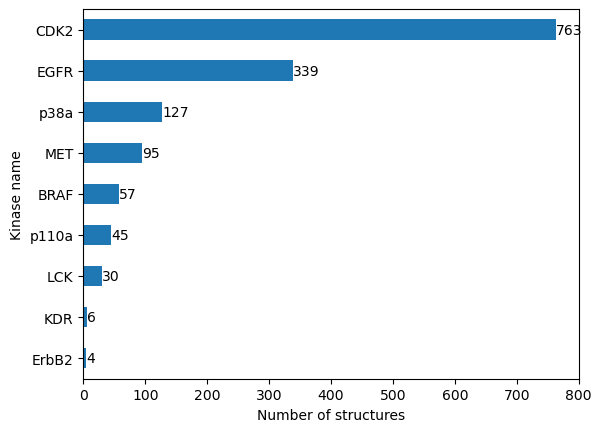

In [14]:
fig, ax = plt.subplots()
n_structures_per_kinase.plot(kind="barh", ax=ax)
ax.set_xlabel("Number of structures")
ax.set_ylabel("Kinase name")
for i, value in enumerate(n_structures_per_kinase):
    ax.text(value, i, str(value), va="center")

We see that our dataset is highly imbalanced. While some kinases are structurally resolved very often, other kinases are not. We will have to keep this in mind when interpreting our results later.

### Compare structures

We will make a pairwise comparison of the structures' IFP using the Tanimoto/Jaccard distance as implemented in `sklearn.metrics.pairwise_distances`, which uses under the hood the method `scipy.spatial.distance`.

#### Prepare IFPs as `numpy` array

KLIFS deposits the IFP as a string of 0's and 1's. We have to convert the IFPs to an array of boolean vectors (required by `scipy.spatial.distance` to be able to use the Jaccard distance). Each row in this array refers to one IFP, each columns to one of the IFP's features.

In [15]:
# This is the KLIFS format of the IFP (structure KLIFS ID and kinase name set as index)
ifp_series = structures_with_ifps_df.set_index(["structure.klifs_id", "kinase.klifs_name"])[
    "interaction.fingerprint"
]
ifp_series.head()
# NBVAL_CHECK_OUTPUT

structure.klifs_id  kinase.klifs_name
775                 EGFR                 0000000000000010000000000000000000000000000000...
777                 EGFR                 0000000000000010000001000000000000000000000000...
778                 EGFR                 0000000000000010000000000000000000000000000000...
779                 EGFR                 0000000000000010000001000000000000000000000000...
782                 EGFR                 0000000000000010000001000000000000000000000000...
Name: interaction.fingerprint, dtype: string

In [16]:
# Cast "0" and "1" to boolean False and True
ifp_series = ifp_series.apply(lambda x: [True if i == "1" else False for i in x])
ifp_series.head()
# NBVAL_CHECK_OUTPUT

structure.klifs_id  kinase.klifs_name
775                 EGFR                 [False, False, False, False, False, False, Fal...
777                 EGFR                 [False, False, False, False, False, False, Fal...
778                 EGFR                 [False, False, False, False, False, False, Fal...
779                 EGFR                 [False, False, False, False, False, False, Fal...
782                 EGFR                 [False, False, False, False, False, False, Fal...
Name: interaction.fingerprint, dtype: object

In [17]:
# Convert to numpy array
ifps_array = np.array(ifp_series.to_list())
ifps_array
# NBVAL_CHECK_OUTPUT

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

#### Calculate pairwise Jaccard distances

The Jaccard distance, defined below, is often used in case of binary fingerprints: 

$$
d_J(A,B) = 1 - J(A,B) = \frac{\mid A \cup B \mid - \mid A \cap B \mid}{\mid A \cup B \mid}.
$$

In [18]:
structure_distance_matrix_array = pairwise_distances(ifps_array, metric="jaccard")

In [19]:
# Create DataFrame with structure KLIFS IDs as index/columns
structure_klifs_ids = ifp_series.index.get_level_values(0)
structure_distance_matrix_df = pd.DataFrame(
    structure_distance_matrix_array, index=structure_klifs_ids, columns=structure_klifs_ids
)
print(f"Structure distance matrix size: {structure_distance_matrix_df.shape}")
print("Show matrix subset:")
structure_distance_matrix_df.iloc[:5, :5]
# NBVAL_CHECK_OUTPUT

Structure distance matrix size: (1466, 1466)
Show matrix subset:


structure.klifs_id,775,777,778,779,782
structure.klifs_id,,,,,
775,0.000000,0.720000,0.542857,0.500000,0.483871
777,0.720000,0.000000,0.741935,0.500000,0.703704
778,0.542857,0.741935,0.000000,0.696970,0.411765
779,0.500000,0.500000,0.696970,0.000000,0.655172
782,0.483871,0.703704,0.411765,0.655172,0.000000


### Map structure to kinase distance matrix

Note: So far we compared individual structures, but we want to compare kinases (which can be represented by several structures, as plotted above).

First, as an intermediate step, we will create a structure distance matrix but &mdash; instead of labeling the data with structure KLIFS IDs &mdash; we use the corresponding kinase name.

In [20]:
kinase_names

['EGFR', 'ErbB2', 'p110a', 'KDR', 'BRAF', 'CDK2', 'LCK', 'MET', 'p38a']

In [21]:
# Copy distance matrix to kinase matrix
kinase_distance_matrix_df = structure_distance_matrix_df.copy()
# Replace structure KLIFS IDs with the structures' kinase names
kinase_names = ifp_series.index.get_level_values(1)
kinase_distance_matrix_df.index = kinase_names
kinase_distance_matrix_df.columns = kinase_names
print("Show matrix subset:")
kinase_distance_matrix_df.iloc[:5, :5]
# NBVAL_CHECK_OUTPUT

Show matrix subset:


kinase.klifs_name,EGFR,EGFR,EGFR,EGFR,EGFR
kinase.klifs_name,,,,,
EGFR,0.000000,0.720000,0.542857,0.500000,0.483871
EGFR,0.720000,0.000000,0.741935,0.500000,0.703704
EGFR,0.542857,0.741935,0.000000,0.696970,0.411765
EGFR,0.500000,0.500000,0.696970,0.000000,0.655172
EGFR,0.483871,0.703704,0.411765,0.655172,0.000000


A kinase pair can be represented by many different structure pairs which are associated with different distance values. 

For example (in the demo mode), if we compare all EGFR structure to each other, the range of distance values is already quite high because we can observe different binding modes of the co-crystallized ligands.

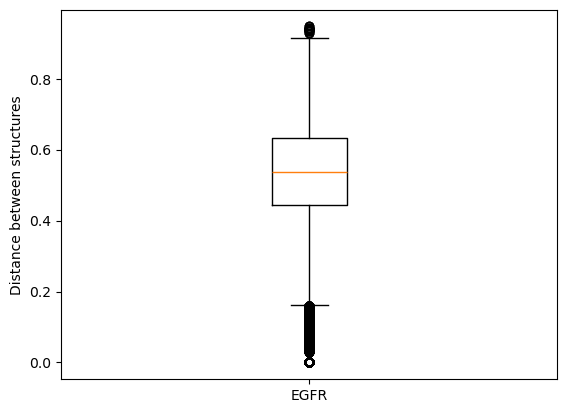

In [22]:
if DEMO:
    example = "EGFR"
else:
    example = kinase_selection_df["kinase_klifs"][0]

# Select EGFR-EGFR structure pairs only
D = kinase_distance_matrix_df.loc[example, example]
# Extract all pairwise distances without identical structure pairs
# = lower triangular matrix without the diagonal
D_condensed = distance.squareform(D)
# Plot pairwise distances
plt.boxplot(D_condensed)
plt.xticks([1], [example])
plt.ylabel("Distance between structures")
plt.show()

In this talktorial, we will consider per kinase pair the two structures that show the most similar binding mode for their co-crystallized ligands. Hence, we select the structure pair with the minimum IFP distance as representative for a kinase pair.

In [23]:
kinases = structures_df["kinase.klifs_name"].unique()
kinase_position = {name: pos for pos, name in enumerate(kinases)}
kinase_names = dict(ifp_series.index)
kinase_distance_matrix = np.ones((len(kinases), len(kinases))) * np.inf
for (structure1, structure2), distance in structure_distance_matrix_df.unstack().items():
    i, j = kinase_position[kinase_names[structure1]], kinase_position[kinase_names[structure2]]
    kinase_distance_matrix[i, j] = min(kinase_distance_matrix[i, j], distance)
kinase_distance_matrix_df = pd.DataFrame(
    data=kinase_distance_matrix, index=kinases, columns=kinases
)

In [24]:
print(
    f"Structure matrix of shape {structure_distance_matrix_df.shape} "
    f"reduced to kinase matrix of shape {kinase_distance_matrix_df.shape}."
)
# NBVAL_CHECK_OUTPUT

Structure matrix of shape (1466, 1466) reduced to kinase matrix of shape (9, 9).


In [25]:
# Show matrix with background gradient
cm = sns.light_palette("green", as_cmap=True)
kinase_distance_matrix_df.style.background_gradient(cmap=cm).format("{:.3f}")

,CDK2,p38a,EGFR,ErbB2,MET,LCK,KDR,BRAF,p110a
CDK2,0.000,0.278,0.111,0.452,0.133,0.190,0.238,0.300,0.348
p38a,0.278,0.000,0.174,0.258,0.353,0.190,0.043,0.333,0.474
EGFR,0.111,0.174,0.000,0.258,0.227,0.167,0.238,0.278,0.381
ErbB2,0.452,0.258,0.258,0.000,0.382,0.419,0.406,0.394,0.571
MET,0.133,0.353,0.227,0.382,0.000,0.250,0.333,0.368,0.429
LCK,0.190,0.190,0.167,0.419,0.250,0.000,0.059,0.320,0.375
KDR,0.238,0.043,0.238,0.406,0.333,0.059,0.000,0.364,0.533
BRAF,0.300,0.333,0.278,0.394,0.368,0.320,0.364,0.000,0.500
p110a,0.348,0.474,0.381,0.571,0.429,0.375,0.533,0.500,0.000


Note: Since this is a distance matrix, lighter colors indicate similarity, darker colors dissimilarity.

### Save kinase distance matrix

In [26]:
kinase_distance_matrix_df.to_csv(DATA / "kinase_distance_matrix.csv")

## Discussion

In this talktorial, we have used the KLIFS interaction fingerprints, which describe binding modes of co-crystallized ligands in kinase structures, to assess kinase similarity.

We have to keep two elements in mind:

- Interaction fingerprints may miss important key interactions if the co-crystallized ligand(s) simply do not form the interaction but other ligands might.
- We only compare here the two closest binding modes per kinase pair, although we have &mdash; for kinases such as EGFR and CDK2 &mdash; much more data available on binding modes. As an alternative, one could instead aggregate the information from multiple binding modes per kinase in a fingerprint that reports all interactions seen in any structure. However, this approach has its own drawbacks: Some kinases have much higher coverage than others, leading to an imbalance in information content.

The kinase distance matrix above will be reloaded in __Talktorial T028__, where we compare kinase similarities from different perspectives, including the interaction perspective we have talked about in this talktorial.

## Quiz

1. What are the advantages and disadvantages of describing kinase similarity with interaction fingerprints?
2. Why is the structural coverage between kinases so different?
3. At one point, we are mapping structure pairs to kinase pairs. We use here the minimum structure distance. What other mapping strategies can you think of? What advantages and disadvantages could they have?